In [1]:


import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mecha.fracture as fracture
import mecha.DIC as dic
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pickle
from tqdm import tqdm

Run complete


In [2]:
#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\aluminum\2021-07-27_tension\64tension_1_ver01'

done
1893


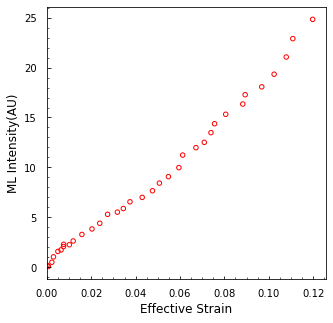

In [8]:
"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\aluminum\2021-07-27_tension\64tension_1_ver01\DIC_img\data'

for i=1:1:35
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""


image = dic.load_file(path+'/DIC_img')

ref = image[list(image.keys())[0]]
print('done')


ratio = 1
scale_factor=2

df = pd.DataFrame(columns=['image_name',
                       'using_DIC_mask_average','DIC_eyy'])

slice_x1 = 135
slice_x2 = 165
slice_y1 = 555
slice_y2 = 595

for num in range(1,35+1):
    file_num = str(num)

    eyy = io.loadmat(path+'/DIC_img/data/'+file_num+'_eyy.mat')['eyy']
    eyy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )

    ml_image = image[list(image.keys())[num]][:,:,0].astype('float')

    ml_image_gas = cv2.GaussianBlur(ml_image,(0,0),10)

    ref_image = image[list(image.keys())[0]][:,:,0].astype('float')
    ref_image_gas = cv2.GaussianBlur(ref_image,(0,0),10)


    image_name = int(list(image.keys())[num].split('_')[1])
    using_DIC_mask_average = np.average(cv2.subtract(
        ml_image[slice_y1:slice_y2, slice_x1:slice_x2],
        ref_image[slice_y1:slice_y2, slice_x1:slice_x2]))

    DIC_eyy = np.average(dic.find_zone(eyy))
    row = pd.Series([image_name,
                     using_DIC_mask_average,DIC_eyy],
                index=['image_name',
                       'using_DIC_mask_average','DIC_eyy'])
    df = df.append(row, ignore_index=True)

"""최소자승법"""
lms_list = []
for k in range(0,5000):
    i = k*0.1
    lms = np.sum(((i * df.DIC_eyy) - df.using_DIC_mask_average)**2)
    lms_list.append(lms)
np.argmin(lms_list)

plt.rcParams["figure.figsize"] = (5,5)

plt.scatter(df.DIC_eyy, df.using_DIC_mask_average, color='red',zorder=1, s=20, marker='o', facecolors='none')
plt.xlabel('Effective Strain')
plt.ylabel('ML Intensity(AU)')

plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
plt.xlim(0,)

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


print(np.argmin(lms_list))